In [21]:
'''
，我们选择了三个不同的高频数据集。其中两个包含逐笔交易数据，第三个包含混合交易的一级数据。资产的选择是随机的，主要受此类数据的可用性影响。高频数据几乎总是收费的，而且价格相当昂贵。考虑到每天产生的海量数据以及存储和分发这些数据的技术难度，这很正常。
For this reason, we will be exploring:
因此，我们将探索：

1.) 从 Kraken 交易所下载的 BTC/USDT 逐笔交易数据：https://support.kraken.com/hc/en-us/articles/360047543791-Downloadable-historical-market-data-time-and-sales-

2.) 从币安交易所下载 RVN/USDT 逐笔交易数据：https://data.binance.vision/

3.) AGLJ/ZAR 一级交易数据下载地址：https://data.mendeley.com/datasets/4rrk89c3b2/2

'''
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# =======================
# 1. 读取 Kraken 的 BTC/USDT Tick 数据
# =======================
# 假设文件 XBTUSDT.csv 已放在当前目录，只有三列：Unix时间戳、价格、数量
btc_usdt = pd.read_csv("XBTUSDT.csv", names=['UNIX_time', 'price', 'volume'])
btc_usdt.head()

# 把 Unix 秒级时间戳转成人类可读的时间，并设为索引
btc_usdt["timestamp"] = pd.to_datetime(btc_usdt["UNIX_time"], unit="s")
btc_usdt.set_index("timestamp", inplace=True)

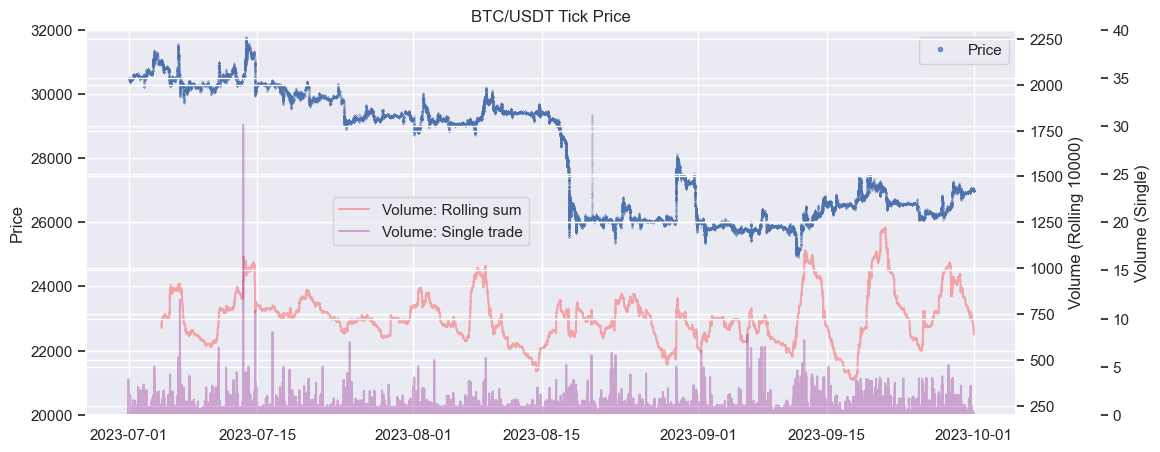

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt



# =======================
# 2. STEP 1：Tick 级“价格 + 成交量”可视化
# =======================
fig, ax_price = plt.subplots(figsize=(12, 5))

# 2.1 价格散点（超多点，用极小的点 s=0.001）
ax_price.scatter(
    btc_usdt.index,
    btc_usdt["price"],
    s=0.001,
    alpha=0.4
)
ax_price.set_ylabel("Price")
ax_price.set_title("BTC/USDT Tick Price")
ax_price.set_ylim(20000, 32000)

# 自定义 legend，让读图更容易
custom_legend = plt.Line2D(
    [0], [0],
    linestyle="none",
    marker="o",
    color="b",
    markersize=3,
    alpha=0.7,
    label="Price"
)
ax_price.legend(handles=[custom_legend], loc="upper right")

# 2.2 第二条 y 轴：10000 笔滚动成交量（粗略看交易热度）
ax_vol_roll = ax_price.twinx()
ax_vol_roll.plot(
    btc_usdt.index,
    btc_usdt["volume"].rolling(10000).sum(),
    color="red",
    alpha=0.3,
    label="Volume: Rolling sum"
)
ax_vol_roll.set_ylabel("Volume (Rolling 10000)")
ax_vol_roll.set_ylim(200, 2300)

# 2.3 第三条 y 轴：单笔成交量
ax_vol_single = ax_price.twinx()
ax_vol_single.plot(
    btc_usdt.index,
    btc_usdt["volume"],
    color="purple",
    alpha=0.3,
    label="Volume: Single trade"
)
ax_vol_single.set_ylabel("Volume (Single)")
ax_vol_single.set_ylim(0, 40)
# 把右侧第三轴往外移 60 像素，避免重叠
ax_vol_single.spines["right"].set_position(("outward", 60))

# 整合 legend
fig.legend(bbox_to_anchor=(0.5, 0.56))
plt.show()

=== 时间差描述性统计 ===
 count    358309.000000
mean         22.184026
std          55.319270
min           0.000000
25%           0.000000
50%           0.000000
75%          20.000000
max        2195.000000
Name: UNIX_time, dtype: float64

=== 最大 10 个时间差（说明有多久没成交）===
 timestamp
2023-08-01 15:41:45    2195.0
2023-07-12 09:19:13    2001.0
2023-08-17 10:30:32    1809.0
2023-08-18 15:05:14    1576.0
2023-07-23 07:29:23    1281.0
2023-07-23 02:13:51    1244.0
2023-08-06 03:40:46    1224.0
2023-09-28 15:28:56    1177.0
2023-07-20 23:44:23    1125.0
2023-07-16 03:52:08    1113.0
Name: UNIX_time, dtype: float64


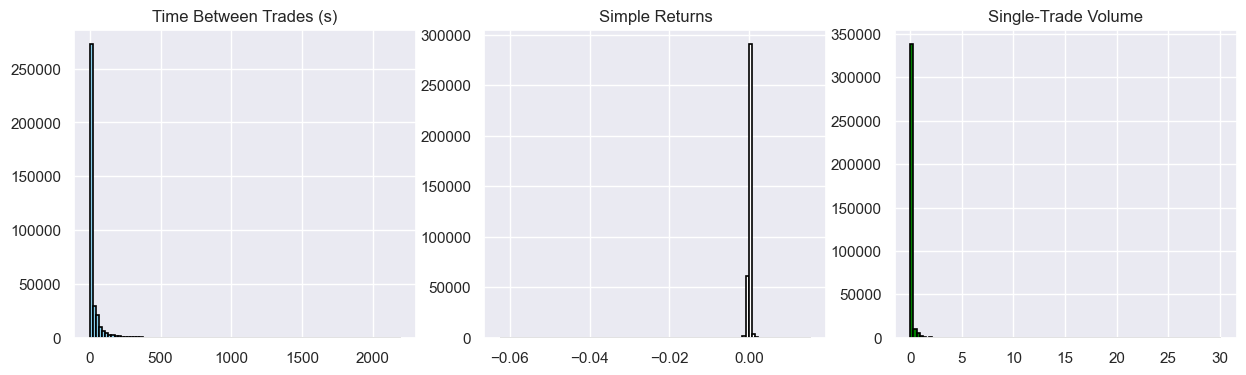

In [23]:

# =======================
# 3. STEP 2：统计时间差 / 收益 / 体量 分布
# =======================
# 3.1 计算相邻两笔的时间差（单位：秒）
between_trades_interval = btc_usdt["UNIX_time"].diff().dropna()

# 3.2 打印描述性统计 & 最大 10 个间隔
print("=== 时间差描述性统计 ===\n", between_trades_interval.describe())
print("\n=== 最大 10 个时间差（说明有多久没成交）===\n",
      between_trades_interval.sort_values(ascending=False).head(10))

# 3.3 三联直方图
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# 时间间隔
ax1.hist(
    between_trades_interval,
    bins=100,
    color="skyblue",
    edgecolor="black",
    linewidth=1.2
)
ax1.set_title("Time Between Trades (s)")

# 简单收益率
ax2.hist(
    btc_usdt["price"].pct_change().dropna(),
    bins=100,
    color="white",
    edgecolor="black",
    linewidth=1.2
)
ax2.set_title("Simple Returns")

# 单笔成交量
ax3.hist(
    btc_usdt["volume"],
    bins=100,
    color="green",
    edgecolor="black",
    linewidth=1.2
)
ax3.set_title("Single-Trade Volume")
plt.show()


同一秒出现多笔的成交数量： 241814
占全部成交笔数百分比： 67.49 %
这些成交的成交量占总量百分比： 90.44 %


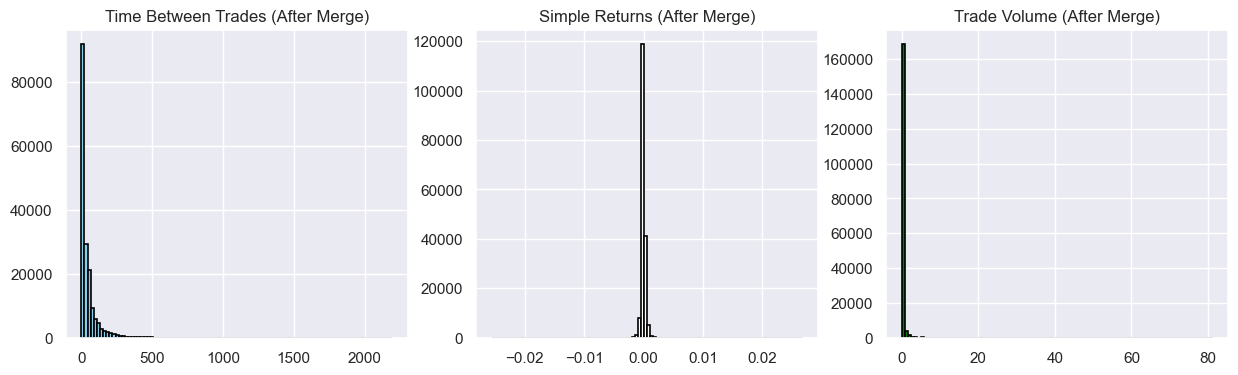

In [24]:

# =======================
# 4. STEP 3：检测并合并“同一秒多笔”（疑似拆单）
# =======================
# 4.1 找到 Unix 时间戳重复行（同一秒发生多笔成交）
is_duplicate = btc_usdt["UNIX_time"].duplicated(keep=False)

# 4.2 快速统计：重复笔数及其占比
dup_count = is_duplicate.sum()
print("\n同一秒出现多笔的成交数量：", dup_count)
print("占全部成交笔数百分比：", round(dup_count / len(btc_usdt) * 100, 2), "%")

# 重复笔的总成交量占比
dup_volume_pct = round(
    ((is_duplicate * btc_usdt["volume"]).sum() / btc_usdt["volume"].sum()) * 100,
    2
)
print("这些成交的成交量占总量百分比：", dup_volume_pct, "%")

# 4.3 把同一秒的拆单合并：
#     价格用 VWAP（成交量加权平均价），数量直接相加
aggr = pd.DataFrame()
# 先按 Unix 秒聚合
aggr["volume"] = btc_usdt["volume"].groupby(btc_usdt["UNIX_time"]).sum()
aggr["price"] = (
                        btc_usdt["price"] * btc_usdt["volume"]
                ).groupby(btc_usdt["UNIX_time"]).sum() / aggr["volume"]
# 把 Unix 秒列恢复出来
aggr["UNIX_time"] = aggr.index
# 把时间索引也重建
aggr.index = pd.to_datetime(aggr["UNIX_time"], unit="s")

# 4.4 再画一遍直方图，看看合并后的分布是否更“干净”
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# 时间间隔
ax1.hist(
    aggr["UNIX_time"].diff().dropna(),
    bins=100,
    color="skyblue",
    edgecolor="black",
    linewidth=1.2
)
ax1.set_title("Time Between Trades (After Merge)")

# 简单收益率
ax2.hist(
    aggr["price"].pct_change().dropna(),
    bins=100,
    color="white",
    edgecolor="black",
    linewidth=1.2
)
ax2.set_title("Simple Returns (After Merge)")

# 合并后的单笔成交量
ax3.hist(
    aggr["volume"],
    bins=100,
    color="green",
    edgecolor="black",
    linewidth=1.2
)
ax3.set_title("Trade Volume (After Merge)")
plt.show()


In [25]:
import glob
import pandas as pd
import numpy as np
'''
一句话概括

教学目的： 把 “谁主动发起了成交” 这一关键信息并进 Tick 数据，顺便示范如何清洗多余字段，减少内存压力。
'''
# ==============================
# 1. 批量读取 RVN/USDT 日度 Tick 文件
# ==============================
list_of_files = glob.glob('RVNUSDT*')          # 找到目录里所有以 RVNUSDT 开头的文件
column_names = [
    'id', 'price', 'qty', 'base_qty',
    'UNIX_time', 'is_buyer_maker', 'is_best_match'
]
# 逐文件读入后纵向拼接成一个 DataFrame
rvn_usdt = pd.concat(
    [pd.read_csv(f, names=column_names) for f in list_of_files],
    ignore_index=True
)
rvn_usdt.sort_values('UNIX_time', inplace=True)  # 先按时间排序
rvn_usdt.head()

,id,price,qty,base_qty,UNIX_time,is_buyer_maker,is_best_match
964617,54407520,0.02588,424.9,10.996412,1680307215745,False,True
964618,54407521,0.02588,3313.5,85.753380,1680307215759,False,True
964619,54407522,0.02588,4172.5,107.984300,1680307215759,False,True
964620,54407523,0.02588,5162.5,133.605500,1680307215762,False,True
964621,54407524,0.02588,1041.3,26.948844,1680307215762,False,True


In [26]:

# ==============================
# 2. 检查额外字段是否有用
# ==============================
print("重复 id 数量：", rvn_usdt['id'].duplicated().sum())
print("非最佳撮合(=价格不是当时最优档)的笔数：",
      (~rvn_usdt['is_best_match']).sum())
print("base_qty 是否能由 price*qty 得出：",
      np.isclose(
          rvn_usdt['price'] * rvn_usdt['qty'],
          rvn_usdt['base_qty'],
          atol=1e-05     # 允许 1e-5 误差
      ).all())

# ==============================
# 3. 删除无用列，转换时间戳
# ==============================
# 根据上一步结果：'id' 仅作去重已用完，'is_best_match' 全 True，
# 删除冗余列（减少40%内存占用）
# 'base_qty' 能由 price*qty 推算 —— 可以安全删除
rvn_usdt.drop(columns=['id', 'is_best_match', 'base_qty'], inplace=True)

# 注意 Binance 的时间戳是毫秒，unit='ms'
rvn_usdt['timestamp'] = pd.to_datetime(rvn_usdt['UNIX_time'], unit='ms')
rvn_usdt.set_index('timestamp', inplace=True)

rvn_usdt.head()


重复 id 数量： 0
非最佳撮合(=价格不是当时最优档)的笔数： 0
base_qty 是否能由 price*qty 得出： True


,price,qty,UNIX_time,is_buyer_maker
timestamp,,,,
2023-04-01 00:00:15.745,0.02588,424.9,1680307215745,False
2023-04-01 00:00:15.759,0.02588,3313.5,1680307215759,False
2023-04-01 00:00:15.759,0.02588,4172.5,1680307215759,False
2023-04-01 00:00:15.762,0.02588,5162.5,1680307215762,False
2023-04-01 00:00:15.762,0.02588,1041.3,1680307215762,False


买方主动成交量： 6081743642.6
卖方主动成交量： 6530522239.8


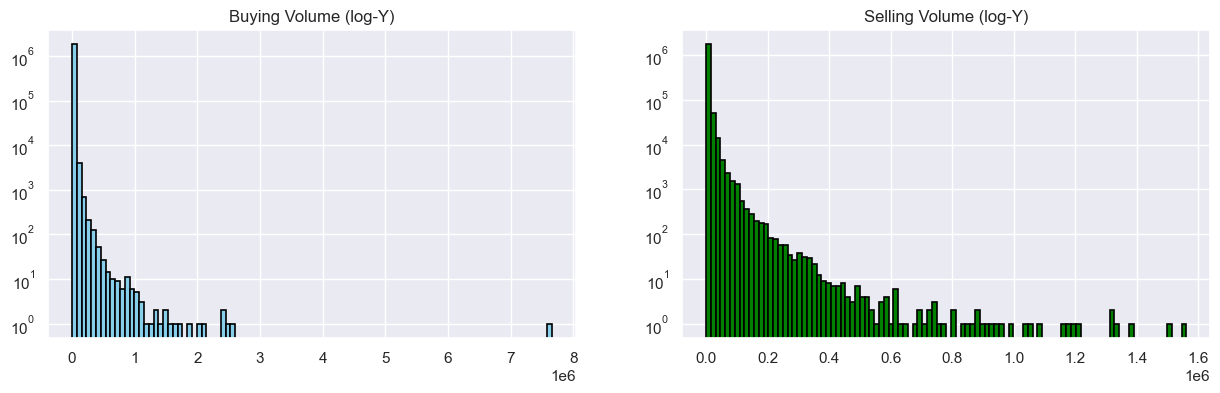

In [27]:
'''
第 5 节　Manipulating Tick Data

核心任务： 把 “谁是主动方” 的信息真正用起来——拆分出买方成交量 / 卖方成交量，

并学会按需放大、缩小画面来观察微观细节。

这会把 X 轴 变成对数刻度（量级 → 对数量级），整个分布更接近正态，便于做统计检验。


'''


# --- 计算买 / 卖成交量 -------------------------------------------------
# is_buyer_maker == True  ➜ 做市方是买家 → 卖家主动出手
buying_volume  = rvn_usdt['qty'] * (~rvn_usdt['is_buyer_maker'])  # 买方主动量
selling_volume = rvn_usdt['qty'] *   rvn_usdt['is_buyer_maker']   # 卖方主动量

print("买方主动成交量：", buying_volume.sum())
print("卖方主动成交量：", selling_volume.sum())

# --- 可视化 -----------------------------------------------------------
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))

# 直方图：Y 轴对数坐标（log=True）→ 能看清长尾小概率
ax1.hist(buying_volume,  bins=100, log=True,
         color='skyblue', edgecolor='black', linewidth=1.2)
ax1.set_title("Buying Volume (log-Y)")

ax2.hist(selling_volume, bins=100, log=True,
         color='green',   edgecolor='black', linewidth=1.2)
ax2.set_title("Selling Volume (log-Y)")
plt.show()


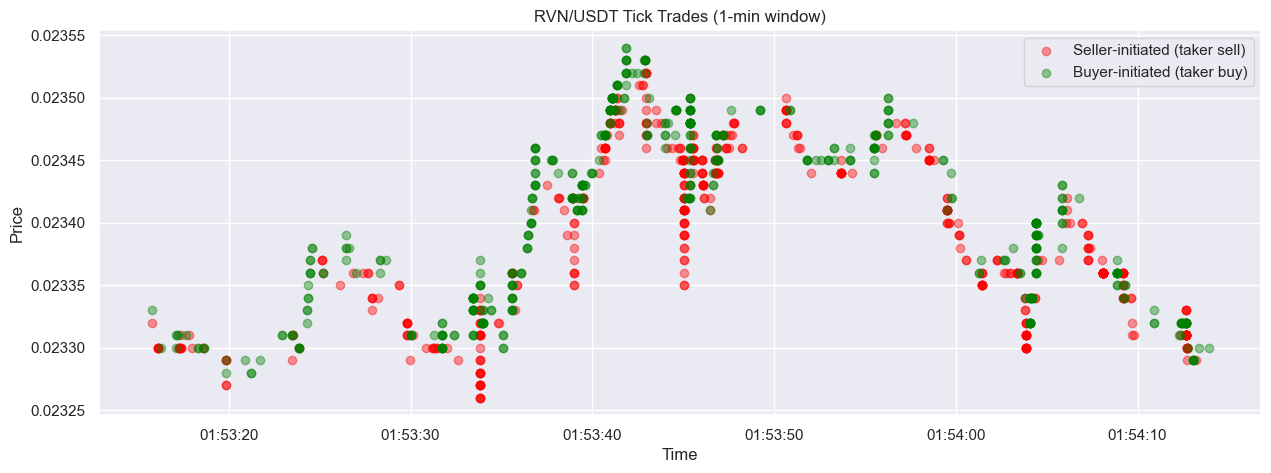

In [28]:
'''
目的：放大到秒级，直观看哪一侧更激进。

观察：若红点密集、绿点稀疏 → 卖方压力；反之亦然。

实战：结合成交量，可以实时监控 买卖盘吸收能力，用于动态调整挂单策略。


'''

# 选取恰好 1 分钟的窗口
rvn_usdt_slice = rvn_usdt.loc['2023-07-01 01:53:15.745' :
                              '2023-07-01 01:54:15.745']

fig, ax = plt.subplots(figsize=(15, 5))

# 卖家主动 (is_buyer_maker == True) ➜ 红点
ax.scatter(rvn_usdt_slice[rvn_usdt_slice['is_buyer_maker']]
           .index,
           rvn_usdt_slice[rvn_usdt_slice['is_buyer_maker']]['price'],
           color='red', alpha=0.4,
           label='Seller-initiated (taker sell)')

# 买家主动 (False) ➜ 绿点
ax.scatter(rvn_usdt_slice[~rvn_usdt_slice['is_buyer_maker']]
           .index,
           rvn_usdt_slice[~rvn_usdt_slice['is_buyer_maker']]['price'],
           color='green', alpha=0.4,
           label='Buyer-initiated (taker buy)')

ax.set_title("RVN/USDT Tick Trades (1-min window)")
ax.set_xlabel("Time")
ax.set_ylabel("Price")
ax.legend()
plt.show()


In [29]:
'''
三、练习2：Tick Size计算方法论
精确定义：
Tick Size = 最小价格变动单位
'''

# 步骤1：获取所有唯一价格
unique_prices = np.sort(rvn_usdt['price'].unique())

# 步骤2：计算连续价格差
price_diffs = np.diff(unique_prices)

# 步骤3：确定最小非零差值
tick_size = np.min(price_diffs[price_diffs > 0])

print(f"RVN/USDT Tick Size: {tick_size:.8f}")

RVN/USDT Tick Size: 0.00001000


In [30]:
'''
五、练习4：交互式分析革命（Plotly实战）
静态图 vs 交互式：
特性	Matplotlib静态图	Plotly交互图
缩放	固定范围	任意缩放
细节	预先指定	鼠标悬停查看
更新	重新生成	实时更新
分享	图片文件	网页链接


import plotly.express as px

# 创建完整数据集可视化
fig = px.scatter(
    rvn_usdt.reset_index(),
    x='timestamp',
    y='price',
    color='is_buyer_maker',
    color_discrete_map={True: 'red', False: 'green'},
    hover_data=['qty'],
    title='RVN/USDT全量Tick数据'
)

# 添加专业金融元素
fig.update_layout(
    xaxis_title='时间',
    yaxis_title='价格',
    hovermode='x unified',
    showlegend=True,
    legend_title_text='交易方向<br>红:卖压 绿:买攻'
)

# 添加技术指标辅助线
fig.add_hline(y=rvn_usdt['price'].mean(),
              line_dash="dot",
              annotation_text="均价线")

# 发布为网页应用
#fig.show()
'''

'\n五、练习4：交互式分析革命（Plotly实战）\n静态图 vs 交互式：\n特性\tMatplotlib静态图\tPlotly交互图\n缩放\t固定范围\t任意缩放\n细节\t预先指定\t鼠标悬停查看\n更新\t重新生成\t实时更新\n分享\t图片文件\t网页链接\n\n\nimport plotly.express as px\n\n# 创建完整数据集可视化\nfig = px.scatter(\n    rvn_usdt.reset_index(),\n    x=\'timestamp\',\n    y=\'price\',\n    color=\'is_buyer_maker\',\n    color_discrete_map={True: \'red\', False: \'green\'},\n    hover_data=[\'qty\'],\n    title=\'RVN/USDT全量Tick数据\'\n)\n\n# 添加专业金融元素\nfig.update_layout(\n    xaxis_title=\'时间\',\n    yaxis_title=\'价格\',\n    hovermode=\'x unified\',\n    showlegend=True,\n    legend_title_text=\'交易方向<br>红:卖压 绿:买攻\'\n)\n\n# 添加技术指标辅助线\nfig.add_hline(y=rvn_usdt[\'price\'].mean(),\n              line_dash="dot",\n              annotation_text="均价线")\n\n# 发布为网页应用\n#fig.show()\n'

In [38]:
from datetime import timedelta, datetime

'''
第 6 节　Level 1 数据：读懂 “买一 / 卖一” 以及清洗流程
一句话目的： 把“盘口最优报价 + 成交”揉到一起，得到一张干净、可同时分析交易和挂单行为的 L1 数据表。

'''
def convert_serial_to_datetime(serial):
    base_date = datetime(1, 1, 1)  # 公元1年1月1日
    days = int(serial) - 367       # 修正公元0年误差
    fractional_day = serial - int(serial)
    seconds = int(fractional_day * 86400)
    return base_date + timedelta(days=days, seconds=seconds)
# 读文件，列包括：报价行(Quote) 与 成交行(Trade)
columns = ['RIC', 'DateTimeL', 'Type', 'Price', 'Volume',
           'L1 Bid', 'L1 Ask', 'Trade Sign']
aglj = (pd.read_csv('AGLJ_J_04-Jan-2016_TO_10-May-2016_5days.csv',
                    names=columns, skiprows=1)
        .sort_values('DateTimeL'))

# 把“从公元 0 年起第 N 天”转成人类能读的时间
aglj['timestamp'] = pd.to_datetime(
    aglj['DateTimeL'].apply(convert_serial_to_datetime)
)
#aglj.drop(columns=['DateTimeL'], inplace=True)
aglj.set_index('timestamp', inplace=True)
aglj.head(5)


,RIC,DateTimeL,Type,Price,Volume,L1 Bid,L1 Ask,Trade Sign
timestamp,,,,,,,,
2016-01-04 09:10:05,AGLJ.J,736333.382013,Trade,6750.0,366.0,0.0,0.0,0
2016-01-04 09:10:05,AGLJ.J,736333.382013,Quote,0.0,0.0,0.0,6800.0,0
2016-01-04 09:10:06,AGLJ.J,736333.382015,Trade,6750.0,374.0,0.0,0.0,0
2016-01-04 09:10:06,AGLJ.J,736333.382015,Quote,0.0,0.0,0.0,6800.0,0
2016-01-04 09:10:06,AGLJ.J,736333.382015,Quote,0.0,0.0,6735.0,6800.0,0


In [40]:
'''
在有效分析高频金融数据之前，清理和预处理数据集至关重要。此清理过程有助于去除错误条目并根据某些市场微观结构的影响进行调整，从而确保我们后续的分析基于准确且有意义的数据。

首先，我们会剔除价格、报价或交易量为零或负值的条目。这些很可能是数据错误，因为金融市场的价格和交易量应该始终为正值。负价差（买入价高于卖出价）也会被剔除，因为它们代表了正常情况下不可能出现的市场状况。

步骤	代码实现	市场意义
无效价格过滤	prices <= 0	排除系统错误报价
负量过滤	Volume <= 0	清除无效交易记录
价差校验	Ask - Bid < 0	防止交叉盘干扰
交易聚合	VWAP计算	还原大单真实成本
报价整合	取最后报价	获取最新市场状态


接下来，我们讨论拆分交易的问题。在高频交易中，一笔大额订单可能会在同一时间戳被拆分成多笔小额交易执行。这可能会导致某些价格水平被过度呈现，并可能影响我们的分析。为了解决这个问题，我们汇总了同一时间戳发生的交易，将其交易量相加，并计算成交量加权平均价格 (VWAP)。
这种方法既保留了整体交易信息，又避免了交易数量的人为膨胀。同样，我们处理秒内报价时，只保留每个时间戳的最后一个报价。这是因为，在快速变化的市场中，最新的报价通常与分析最为相关。
'''
# =========================================================
# 1️⃣  剔除异常价格 / 数量 / 报价
# =========================================================
prices = aglj[aglj['Type'] == ' Trade']['Price']          # ① 只拿成交行的价格
quotes = aglj[aglj['Type'] == ' Quote'][['L1 Bid','L1 Ask']]  # ② 只拿报价行的买一 / 卖一

# ③ 统计有多少行价格≤0（不合法）
print("成交价 ≤0 的条数:", (prices <= 0).sum())
# ④ 统计有多少行成交量≤0
print("成交量 ≤0 的条数:", (aglj[aglj['Type']==' Trade']['Volume'] <= 0).sum())
# ⑤ 统计买一、卖一报价 ≤0 的条数
print("买一 / 卖一 ≤0 的条数:", (quotes <= 0).sum().sum())

# ⑥ 找出买一或卖一 ≤0 的索引
index_to_drop_quotes = (quotes[quotes['L1 Ask'] <= 0].index
                        .union(quotes[quotes['L1 Bid'] <= 0].index))
aglj.drop(index=index_to_drop_quotes, inplace=True)        # ⑦ 直接删除

# =========================================================
# 2️⃣  删除负点差（Bid > Ask）
# =========================================================
spreads = (aglj[aglj['Type']==' Quote']['L1 Ask'] -
           aglj[aglj['Type']==' Quote']['L1 Bid'])         # ① 计算每行报价差
index_to_drop_spreads = spreads[spreads < 0].index         # ② 取出负差索引
print("负点差条数:", len(index_to_drop_spreads))
aglj.drop(index=index_to_drop_spreads, inplace=True)       # ③ 删除

# =========================================================
# 3️⃣  合并“同一时间戳多笔成交” → VWAP
# =========================================================
dataset_on_trades = aglj[aglj['Type'] == ' Trade']         # ① 只保留成交行
unique_trades = pd.DataFrame()
# ② 同一时间戳的第一条行作代表（方便后面 join）
unique_trades['DateTimeL'] = (dataset_on_trades['DateTimeL']
                              .groupby(dataset_on_trades['DateTimeL']).first())
# ③ 把成交量累加
unique_trades['Volume'] = (dataset_on_trades['Volume']
                           .groupby(dataset_on_trades['DateTimeL']).sum())
# ④ VWAP：∑(价×量) / ∑量
unique_trades['Price'] = ((dataset_on_trades['Price'] *
                           dataset_on_trades['Volume'])
                          .groupby(dataset_on_trades['DateTimeL']).sum()
                          / unique_trades['Volume'])
unique_trades.drop(columns='DateTimeL', inplace=True)

# =========================================================
# 4️⃣  同秒多次报价 → 只留最后一条
# =========================================================
dataset_on_quotes = aglj[aglj['Type'] == ' Quote']         # ① 只保留报价行
unique_quotes = pd.DataFrame()
unique_quotes['DateTimeL'] = (dataset_on_quotes['DateTimeL']
                              .groupby(dataset_on_quotes['DateTimeL']).last())
unique_quotes['L1 Bid'] = (dataset_on_quotes['L1 Bid']
                           .groupby(dataset_on_quotes['DateTimeL']).last())
unique_quotes['L1 Ask'] = (dataset_on_quotes['L1 Ask']
                           .groupby(dataset_on_quotes['DateTimeL']).last())
unique_quotes.drop(columns='DateTimeL', inplace=True)

# =========================================================
# 5️⃣  把“成交表”和“报价表”合并
# =========================================================
aggr_dataset_2 = pd.merge(unique_trades, unique_quotes,
                          on='DateTimeL', how='outer')    # 外连接，确保时间轴唯一

# ⑥ 新增列 Type：有 Price 就是 Trade，反之 Quote
aggr_dataset_2['Type'] = np.where(aggr_dataset_2['Price'].isnull(),
                                  ' Quote',' Trade')

# ⑦ 补回 Trade Sign（买卖方向），取原数据里同一秒的最后一条
mask = (aglj['DateTimeL'].isin(aggr_dataset_2[aggr_dataset_2['Type']==' Trade'].index) &
        (aglj['Type']==' Trade'))
aggr_dataset_2['Trade Sign'] = (aglj[mask]
                                .groupby('DateTimeL')['Trade Sign']
                                .last())

# ⑧ 重新设置索引 & 把序列日期转成人类时间
aggr_dataset_2.reset_index(inplace=True)
aggr_dataset_2.index = pd.to_datetime(
    aggr_dataset_2['DateTimeL'].apply(convert_serial_to_datetime)
)

print(aggr_dataset_2.head())
print(f"清洗聚合后行数: {len(aggr_dataset_2)}, 原始行数: {len(aglj)}")
aggr_dataset_2.head(5)


成交价 ≤0 的条数: 0
成交量 ≤0 的条数: 0
买一 / 卖一 ≤0 的条数: 0
负点差条数: 0
                         DateTimeL  Volume  Price  L1 Bid  L1 Ask    Type  \
DateTimeL                                                                   
2016-01-04 09:10:20  736333.382180     NaN    NaN  6751.0  6800.0   Quote   
2016-01-04 09:10:20  736333.382182     NaN    NaN  6751.0  6800.0   Quote   
2016-01-04 09:10:21  736333.382190     NaN    NaN  6755.0  6800.0   Quote   
2016-01-04 09:10:21  736333.382192     NaN    NaN  6757.0  6800.0   Quote   
2016-01-04 09:10:42  736333.382433     NaN    NaN  6759.0  6800.0   Quote   

                     Trade Sign  
DateTimeL                        
2016-01-04 09:10:20         NaN  
2016-01-04 09:10:20         NaN  
2016-01-04 09:10:21         NaN  
2016-01-04 09:10:21         NaN  
2016-01-04 09:10:42         NaN  
清洗聚合后行数: 134724, 原始行数: 185210


,DateTimeL,Volume,Price,L1 Bid,L1 Ask,Type,Trade Sign
DateTimeL,,,,,,,
2016-01-04 09:10:20,736333.382180,NaN,NaN,6751.0,6800.0,Quote,NaN
2016-01-04 09:10:20,736333.382182,NaN,NaN,6751.0,6800.0,Quote,NaN
2016-01-04 09:10:21,736333.382190,NaN,NaN,6755.0,6800.0,Quote,NaN
2016-01-04 09:10:21,736333.382192,NaN,NaN,6757.0,6800.0,Quote,NaN
2016-01-04 09:10:42,736333.382433,NaN,NaN,6759.0,6800.0,Quote,NaN


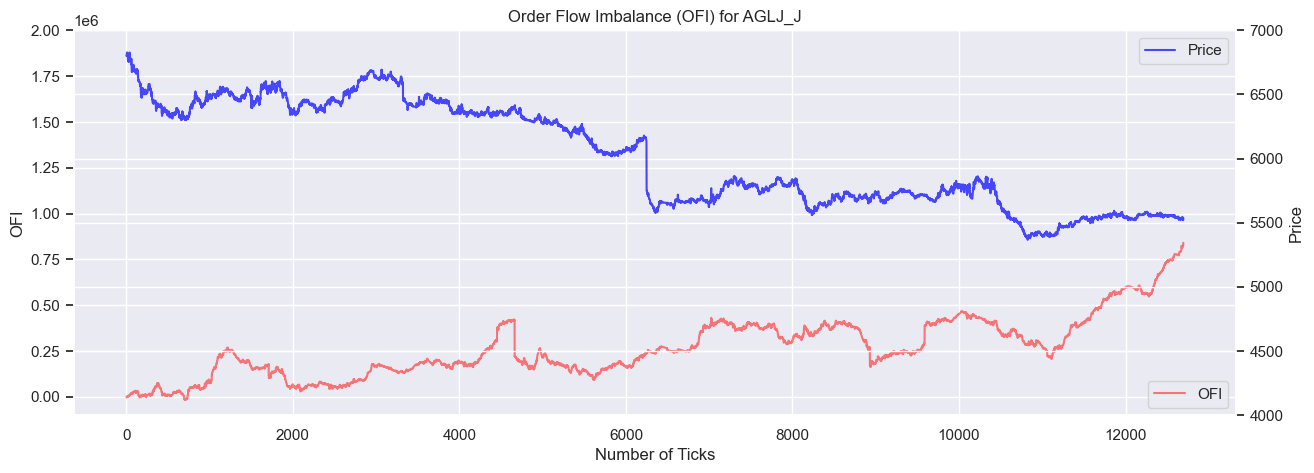

Price 与 OFI 的皮尔逊相关: -0.7358121189051724


In [41]:
'''
第 7 章整体导读——把「买卖压力」量化成一条线
你要搞懂的关键词	一句话破题	为什么重要？
OFI（Order-Flow Imbalance）	把每笔成交按“谁先动手”带方向累加，得出净买卖量。	高频世界里，比起只看价格，买/卖动能常能更早预示拐点。
Trade Sign	买家主动＝+1，卖家主动＝-1。	决定一笔量对 OFI 的正负贡献。
累积和 / cumsum	把带符号的成交量一路相加。	得到随时间滚动的“买卖力量天平”。
双轴对照	左轴画 OFI，右轴画价格。	让我们肉眼对比“动能 vs. 价格”是否同向。
相关系数：Pearson, Spearman, Kendall	分别看线性、单调、秩序相关。	OFI 与价格往往非线性，需多角度验证。
图 7：盘口 + 成交点	step 画 L1 Bid/Ask，scatter 画主动买/卖成交。	联合观察“价差变化”与“谁在吃单”。

'''

# ================================================================
# ① 计算最简单的 OFI：成交量 × 买卖方向 (Trade Sign)
# ================================================================
signed_volume = (
        aggr_dataset_2[aggr_dataset_2['Type'] == ' Trade']['Volume']   # 只取成交行的量
        * aggr_dataset_2[aggr_dataset_2['Type'] == ' Trade']['Trade Sign']  # ±1 表示买/卖
)

# ================================================================
# ② 对 signed_volume 做累积和 → 当前时刻净买卖量
# ================================================================
ofi = signed_volume.cumsum()

# ================================================================
# ③ 同步拿出成交价，准备画双 Y 轴
# ================================================================
prices = aggr_dataset_2[aggr_dataset_2['Type'] == ' Trade']['Price']

# ================================================================
# ④ 画图：左轴 OFI（红线）；右轴 价格（蓝线）
# ================================================================
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(np.arange(len(ofi)), ofi,
        color='red', alpha=0.5, label='OFI')
ax.set_ylabel('OFI')
ax.set_xlabel('Number of Ticks')
ax.set_ylim(-100_000, 2_000_000)
ax.set_title('Order Flow Imbalance (OFI) for AGLJ_J')
ax.legend(loc='lower right')

ax2 = ax.twinx()   # 创建第二条 Y 轴
ax2.plot(np.arange(len(prices)), prices,
         color='blue', alpha=0.7, label='Price')
ax2.set_ylabel('Price')
ax2.set_ylim(4000, 7000)
ax2.legend()

plt.show()

# ================================================================
# ⑤ 计算线性相关系数（皮尔逊 r）
# ================================================================
print("Price 与 OFI 的皮尔逊相关:", np.corrcoef(prices, ofi)[0, 1])


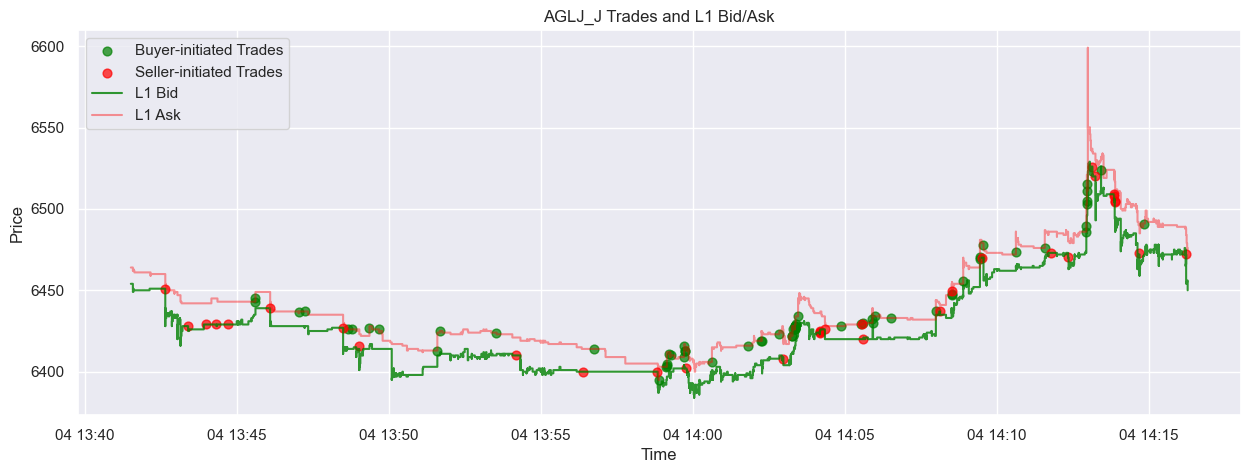

In [42]:
# ================================================================
# ① 选定一个时间窗口：2016-01-04，切第 15000–17000 行
# ================================================================
zoomed = aggr_dataset_2.loc['2016-01-04'].iloc[15_000:17_000]

fig, ax = plt.subplots(figsize=(15, 5))

# ================================================================
# ② 画买方主动成交（Trade Sign = 1）→ 绿色散点
# ================================================================
ax.scatter(
    zoomed[
        (zoomed['Type'] == ' Trade') & (zoomed['Trade Sign'] == 1)
        ].index,
    zoomed[
        (zoomed['Type'] == ' Trade') & (zoomed['Trade Sign'] == 1)
        ]['Price'],
    color='green', s=40, alpha=0.7,
    label='Buyer-initiated Trades'
)

# ================================================================
# ③ 画卖方主动成交（Trade Sign = –1）→ 红色散点
# ================================================================
ax.scatter(
    zoomed[
        (zoomed['Type'] == ' Trade') & (zoomed['Trade Sign'] == -1)
        ].index,
    zoomed[
        (zoomed['Type'] == ' Trade') & (zoomed['Trade Sign'] == -1)
        ]['Price'],
    color='red', s=40, alpha=0.7,
    label='Seller-initiated Trades'
)

# ================================================================
# ④ 画 L1 Bid / Ask：用 step 图，where='post'
#    - 'post' 表示“台阶在 x 点之后保持该值”
# ================================================================
ax.step(
    zoomed[zoomed['Type'] == ' Quote'].index,
    zoomed[zoomed['Type'] == ' Quote']['L1 Bid'],
    color='green', alpha=0.8, where='post', label='L1 Bid'
)
ax.step(
    zoomed[zoomed['Type'] == ' Quote'].index,
    zoomed[zoomed['Type'] == ' Quote']['L1 Ask'],
    color='red', alpha=0.4, where='post', label='L1 Ask'
)

ax.set_title("AGLJ_J Trades and L1 Bid/Ask")
ax.set_xlabel("Time")
ax.set_ylabel("Price")
ax.legend()
plt.show()


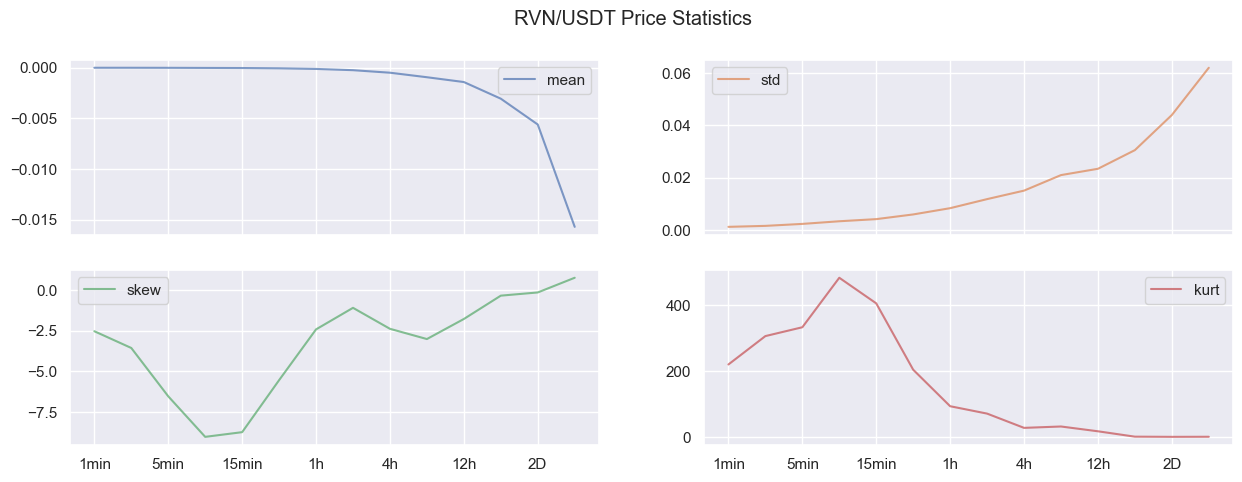

In [43]:


'''

| 核心                  | 一句话说明                                      | 为什么要关心                             |
| ------------------- | ------------------------------------------ | ---------------------------------- |
| **`resample()`**    | 让 datetime 索引的数据一次变成任意频率的“时间条”（time bars）。 | 大多策略、图表都基于 1 min/1 h/1 D K 线。      |
| **`label="right"`** | 重采样区间的 **右端点** 作为新时间戳。                     | 和常见的蜡烛图对齐——“这一分钟的柱子时间写在 00:01:00”。 |
| **统计量随尺度**          | 均值≈0 → 标准差 ∝ √Δt → 小尺度高峰厚尾。                | 体现微观噪声、布朗运动刻度律、中心极限定理。             |


| 指标随时间窗 Δt   | 你会看到                          | 原因（通俗 + 模型）                         |
| ----------- | ----------------------------- | ----------------------------------- |
| **均值 μ**    | 1–30 min 几乎 0，往后略起伏。          | 单笔涨跌太小、方向随机；符合“公平游戏”马丁格尔。           |
| **标准差 σ**   | 随 Δt 单调上升，且大致 \~ √Δt。         | Brownian Motion 变差线性随时长；σ = √(Var)。 |
| **偏度 Skew** | 从近 0 微升到略正。                   | 长周期里，偶尔的大涨幅高于下跌幅。                   |
| **峰度 Kurt** | 1 min 极高（厚尾），随尺度下降但仍 > 3（正态）。 | 微观结构：报价跳动、拆单、极端事件多；聚合后中央极限定理拉向正态。   |

'''
def resample(df, freq):
    """把逐笔 DataFrame 聚成 freq 频率的 OHLCV。"""
    tmp = (df.resample(freq, label='right')
           .agg({'price': 'ohlc',      # 开高低收
                 'qty'  : 'sum'}))     # 成交量加总
    tmp.columns = tmp.columns.droplevel(0)    # 把多层列名拍平
    return tmp

# 生成多种时间尺度的 DataFrame
timeframes = ['1min','2min','5min','10min','15min',
              '30min','1h','2h','4h','8h','12h','1D','2D','5D']

stats = {}
for tf in timeframes:
    ohlcv = resample(rvn_usdt, tf)
    log_ret = np.log(ohlcv['close'] / ohlcv['close'].shift(1)).dropna()
    stats[tf] = {
        'mean'   : log_ret.mean(),
        'std'    : log_ret.std(),
        'skew'   : log_ret.skew(),
        'kurt'   : log_ret.kurt()
    }

(pd.DataFrame(stats).T
 .plot(subplots=True, layout=(2,2), figsize=(15,5),
       title='RVN/USDT Price Statistics', alpha=.7))
plt.show()


In [44]:
'''

8.4 Exercise 10 参考实现
目标：生成同样的 OHLCV，但多两列 buying_volume / selling_volume。

python
Copier
Modifier

'''

def resample_with_side(df, freq):
    agg = (df.resample(freq, label='right')
    .agg(
        price=('price', 'ohlc'),
        qty=('qty', 'sum'),
        buying_volume=('qty',  lambda x: x[~df.loc[x.index,'is_buyer_maker']].sum()),
        selling_volume=('qty', lambda x: x[df.loc[x.index,'is_buyer_maker']].sum())
    ))
    # 展平列索引
    agg.columns = ['open','high','low','close','volume',
                   'buy_vol','sell_vol']
    return agg

bars_5min = resample_with_side(rvn_usdt, '5min').head()


IndexError: boolean index did not match indexed array along axis 0; size of axis is 112 but size of corresponding boolean axis is 952